In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline


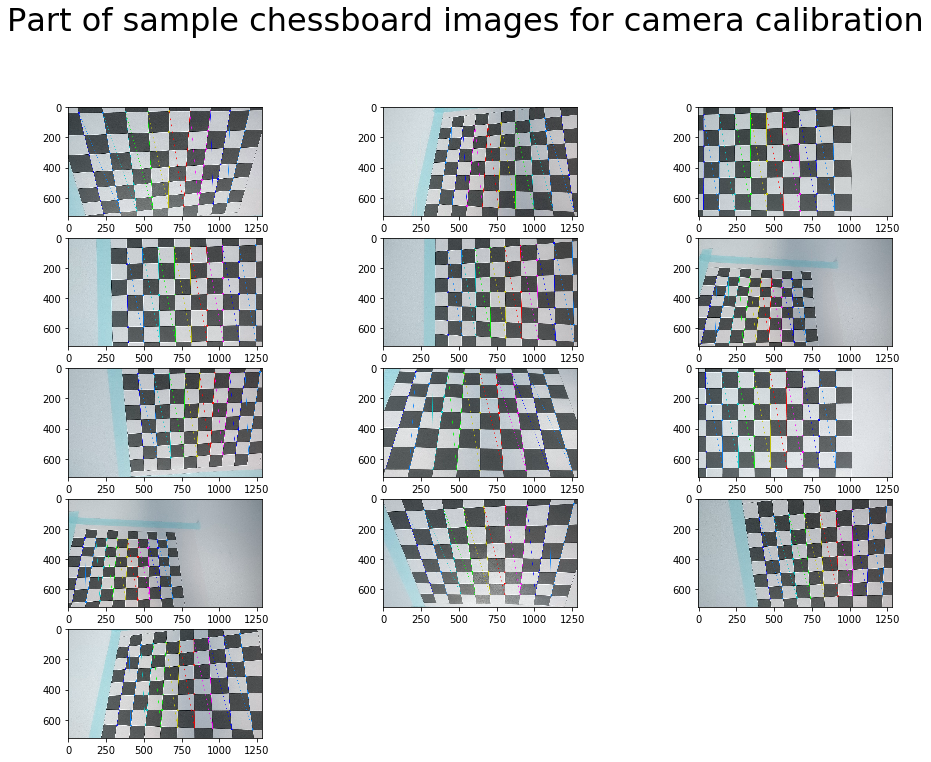

In [2]:
imgSize = (1280, 720)

calChessboardPattern = (7, 9)
calImgsPath = glob.glob("./ccalib-test-images-5/*.jpg")

objPoints = []
imgPoints = []

objPt = np.zeros((calChessboardPattern[0] * calChessboardPattern[1], 3), np.float32)
objPt[:, :2] = np.mgrid[0:calChessboardPattern[0], 0:calChessboardPattern[1]].T.reshape(-1, 2)

fig = plt.figure(figsize=(16, 14))
fig.suptitle("Part of sample chessboard images for camera calibration", fontsize=32)
columns = 3
rows = 6
i = 1

for image in calImgsPath:
    calImg = cv2.imread(image)
    ret, corners = cv2.findChessboardCorners(calImg, calChessboardPattern)
    
    if ret:
        imgPoints.append(corners)
        objPoints.append(objPt)
        cv2.drawChessboardCorners(calImg, calChessboardPattern, corners, ret)
        if i <= rows * columns:
            sub_i = fig.add_subplot(rows, columns, i)
            plt.imshow(calImg,  cmap='gray')
            i += 1
        else:
            break
plt.show()

In [3]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imgSize, None, None)

In [4]:
print("Camera matrix: \n", cameraMatrix)
print("\nDistortion coefficients: \n", distCoeffs)

Camera matrix: 
 [[1.03541773e+03 0.00000000e+00 6.47490892e+02]
 [0.00000000e+00 1.02848296e+03 3.49379086e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients: 
 [[-0.01724175  0.01293847 -0.00040578 -0.00083023  0.08450202]]


In [5]:
optimAlpha = 1
optimCameraMatrix, cameraROI = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, imgSize, optimAlpha)
print("Optimal camera matrix: \n", optimCameraMatrix)
print("\nRegion of interest:\n", cameraROI)

Optimal camera matrix: 
 [[1.03546729e+03 0.00000000e+00 6.46361563e+02]
 [0.00000000e+00 1.02560950e+03 3.49186776e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Region of interest:
 (4, 3, 1273, 713)


In [6]:
def undistortImage(img):
    imgUndistRaw = imgUndist = cv2.undistort(img, cameraMatrix, distCoeffs, None, optimCameraMatrix)
    x, y, w, h = cameraROI
    x, y, w, h = int(x), int(y), int(w), int(h)
    imgUndistCrop = imgUndist[y:y + h, x:x + w]
    imgUndistScaled = cv2.resize(imgUndistCrop, imgSize)
    return imgUndistScaled, imgUndistCrop, imgUndistRaw

True

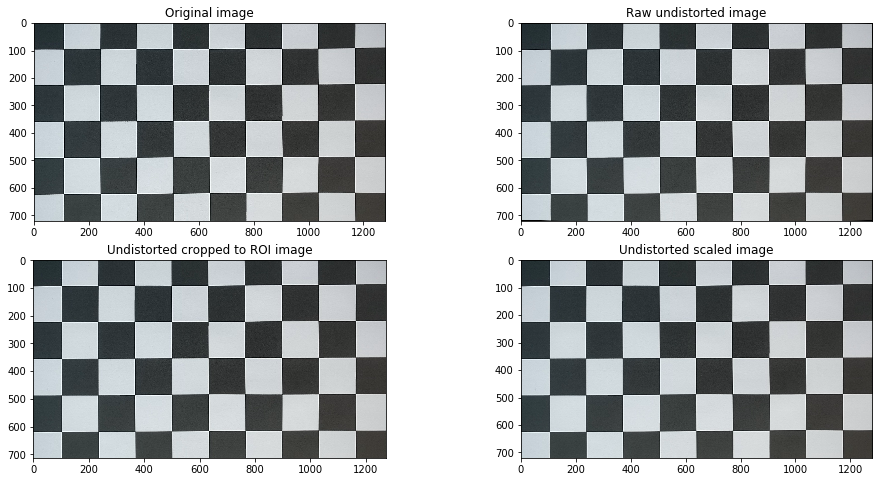

In [7]:
testImg = cv2.imread("./samples/double_chessboard_2.jpg")
testUndistScaled, testUndistCrop, testUndistRaw = undistortImage(testImg)
fig = plt.figure(figsize=(16, 8))

sub1 = fig.add_subplot(2, 2, 1)
sub1.set_title("Original image")
plt.imshow(testImg)

sub2 = fig.add_subplot(2, 2, 2)
sub2.set_title("Raw undistorted image")
plt.imshow(testUndistRaw)

sub3 = fig.add_subplot(2, 2, 3)
sub3.set_title("Undistorted cropped to ROI image")
plt.imshow(testUndistCrop)
           
sub4 = fig.add_subplot(2, 2, 4)
sub4.set_title("Undistorted scaled image")
plt.imshow(testUndistScaled)
cv2.imwrite("./samples/double_chessboard_2_result.jpg", testUndistScaled)

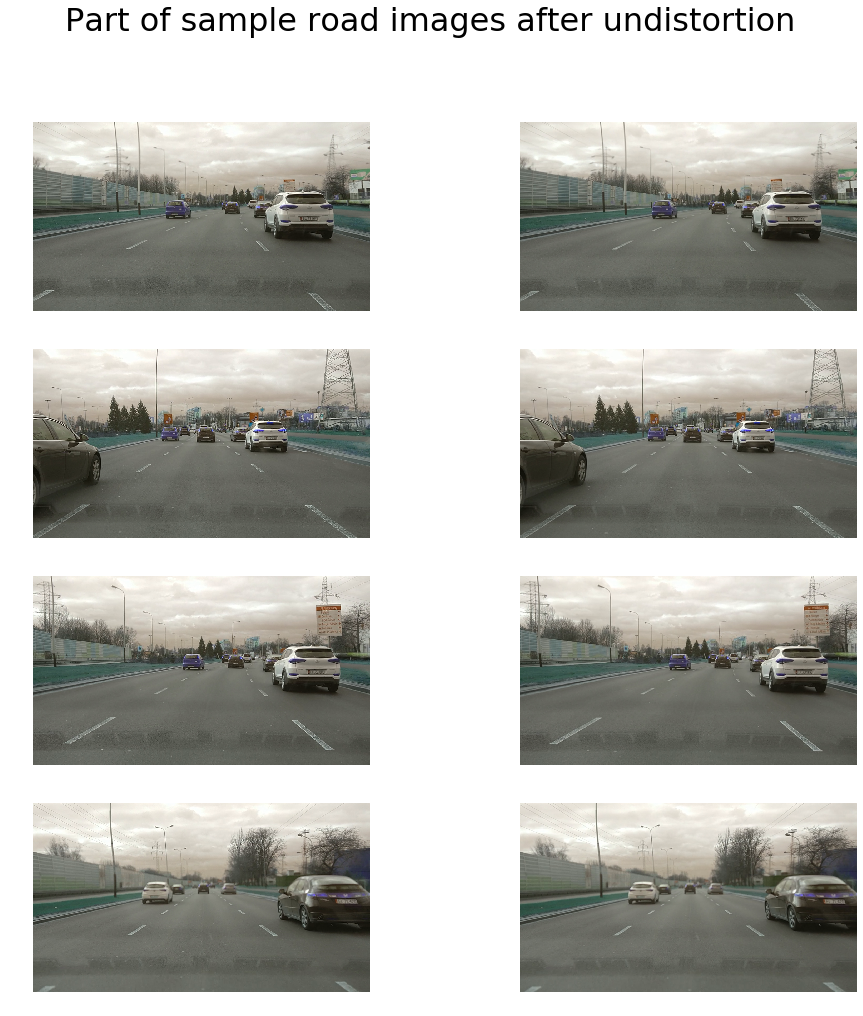

In [8]:
sampleRoadImgs = glob.glob("./samples/road_samples_1/raw/*.png")

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Part of sample road images after undistortion", fontsize=32)
columns = 2
rows = 4
i = 1

for image in sampleRoadImgs:
    img = cv2.imread(image)
    imgUndist, _, _ = undistortImage(img)
    cv2.imwrite("./samples/road_samples_1/undistorted/"+os.path.basename(image).replace(".png", "_undist.png"), imgUndist)
    if i <= columns * rows:
        sub_i = fig.add_subplot(rows, columns, i).axis('off')
        plt.imshow(img)
        i += 1
        sub_i = fig.add_subplot(rows, columns, i).axis('off')
        plt.imshow(imgUndist)
        i += 1
plt.show()

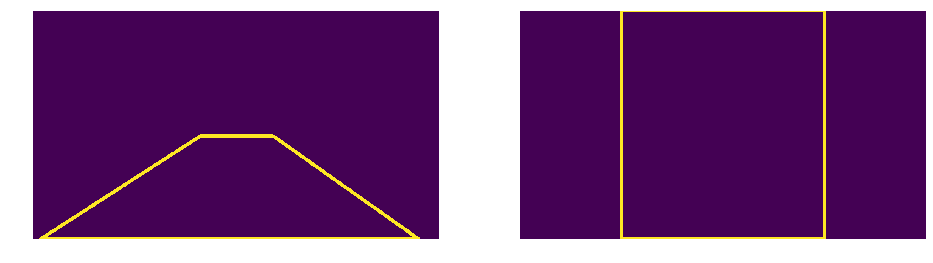

In [9]:
srcWarpPoints = np.float32([[23, imgSize[1]], [1216, imgSize[1]],
                        [757, imgSize[1] * 0.55], [527, imgSize[1] * 0.55]])

dstWarpPoints = np.float32([[imgSize[0] / 4, imgSize[1]],
                         [imgSize[0] * 3 / 4, imgSize[1]],
                         [imgSize[0] * 3 / 4, 0],
                         [imgSize[0] / 4, 0]])

warpMatrix = cv2.getPerspectiveTransform(srcWarpPoints, dstWarpPoints)

def drawWarpLines(img, imgWarped):
    for i in range(4):
        cv2.line(img, tuple(srcWarpPoints[i]), tuple(srcWarpPoints[(i + 1) % 4]), (255, 0, 0), thickness=10)
        cv2.line(imgWarped, tuple(dstWarpPoints[i]), tuple(dstWarpPoints[(i + 1) % 4]), (255, 0, 0), thickness=10)
    return img, imgWarped

blackOrg = np.zeros(imgSize[::-1])
blackWarp = np.zeros(imgSize[::-1])
blackOrg, blackWarp = drawWarpLines(blackOrg, blackWarp)

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1, 2, 1).axis('off')
plt.imshow(blackOrg)
fig.add_subplot(1, 2, 2).axis('off')
plt.imshow(blackWarp)

In [10]:
def warpView(img):
    imgWarped = cv2.warpPerspective(img, warpMatrix, imgSize)
    return imgWarped

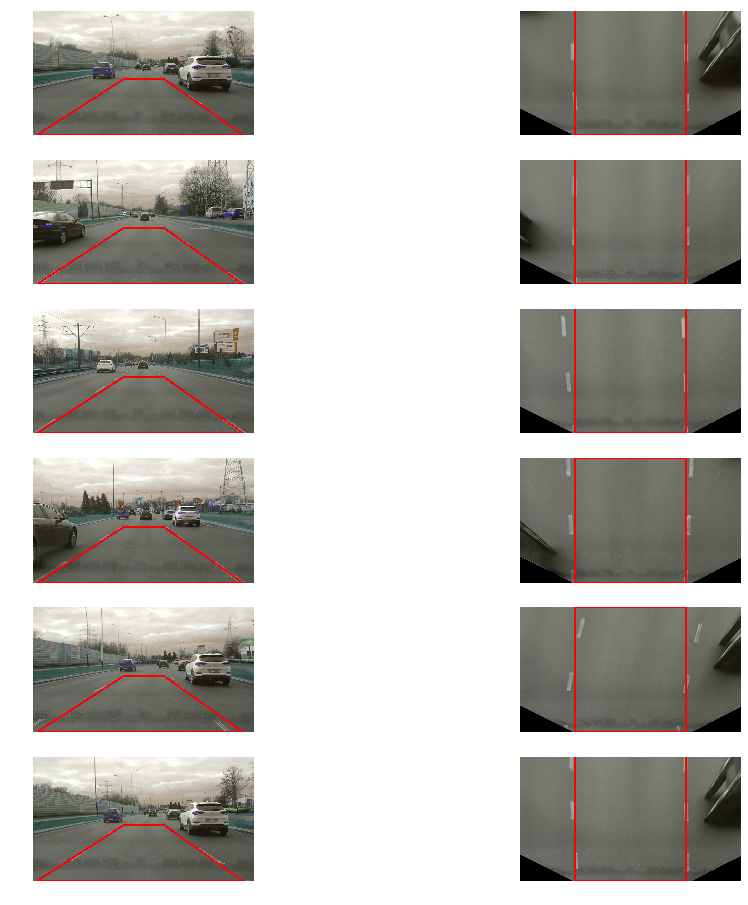

In [11]:
sampleRoadImgs = glob.glob("./samples/road_samples_1/undistorted/*.png")

fig = plt.figure(figsize=(16, 16))
columns = 2
rows = 6
i = 1

for image in sampleRoadImgs:
    img = cv2.imread(image)
    imgWarped = warpView(img)
    cv2.imwrite("./samples/road_samples_1/warped/"+os.path.basename(image).replace("_undist.png", "_warped.png"), imgWarped)
    if i <= columns * rows:
        img, imgWarped = drawWarpLines(img, imgWarped)
        sub_i = fig.add_subplot(rows, columns, i).axis('off')
        plt.imshow(img)
        i += 1
        sub_i = fig.add_subplot(rows, columns, i).axis('off')
        plt.imshow(imgWarped)
        i += 1
plt.show()

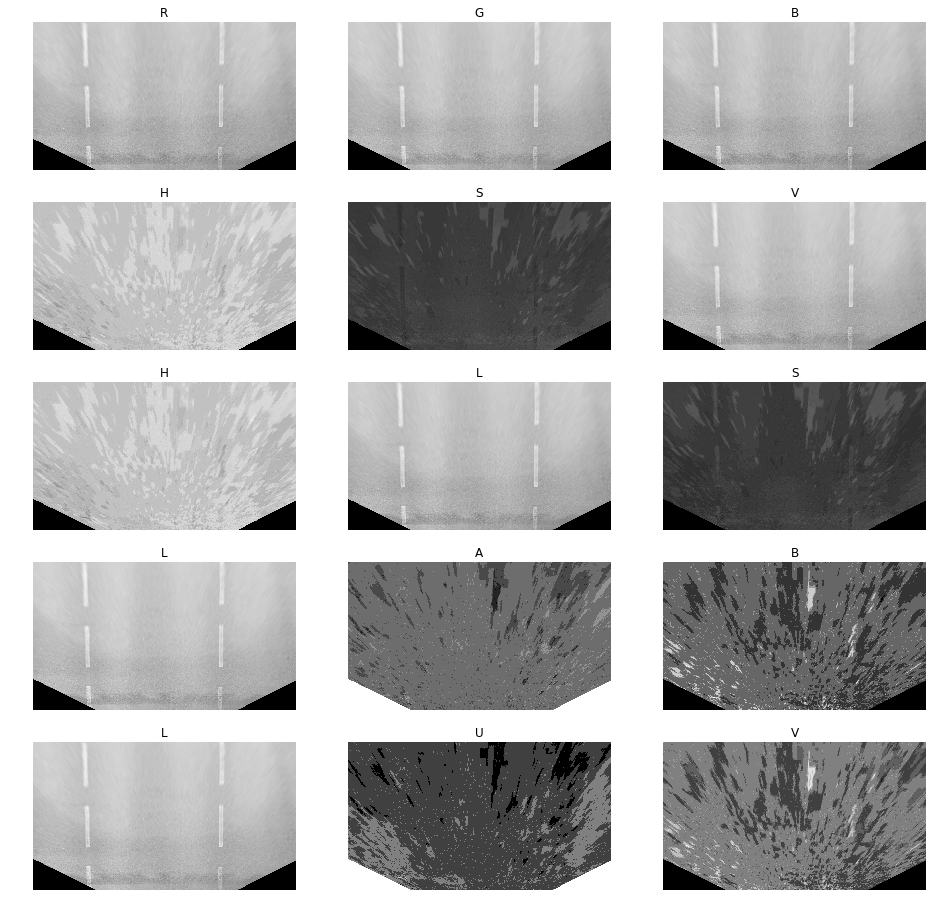

In [12]:
# sampleRoadImgs = glob.glob("./samples/road_samples_1/warped/*.png")

# for image in sampleRoadImgs:
fig = plt.figure(figsize=(16, 16))
columns = 3
rows = 5
# imgRGB = cv2.imread(image)
# imgBGR = cv2.imread("./samples/road_samples_1/warped/yellow_white_sample_warped.png")
imgBGR = cv2.imread("./samples/road_samples_1/warped/sample_road_img_5_warped.png")
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

imgRGB_R, imgRGB_G, imgRGB_B = cv2.split(imgBGR)

imgHSV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
imgHSV_H, imgHSV_S, imgHSV_V = cv2.split(imgHSV)

imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
imgHLS_H, imgHLS_L, imgHLS_S = cv2.split(imgHLS)

imgLUV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LUV)
imgLUV_L, imgLUV_U, imgLUV_V = cv2.split(imgLUV)

imgLAB = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LAB)
imgLAB_L, imgLAB_A, imgLAB_B = cv2.split(imgLAB)

subRGB_R = fig.add_subplot(rows, columns, 1)
subRGB_R.axis('off')
subRGB_R.set_title('R')
plt.imshow(imgRGB_R, cmap='gray')
subRGB_G = fig.add_subplot(rows, columns, 2)
subRGB_G.axis('off')
subRGB_G.set_title('G')
plt.imshow(imgRGB_G, cmap='gray')
subRGB_B = fig.add_subplot(rows, columns, 3)
subRGB_B.axis('off')
subRGB_B.set_title('B')
plt.imshow(imgRGB_B, cmap='gray')

subHSV_H = fig.add_subplot(rows, columns, 4)
subHSV_H.axis('off')
subHSV_H.set_title('H')
plt.imshow(imgHSV_H, cmap='gray')
subHSV_S = fig.add_subplot(rows, columns, 5)
subHSV_S.axis('off')
subHSV_S.set_title('S')
plt.imshow(imgHSV_S, cmap='gray')
subHSV_V = fig.add_subplot(rows, columns, 6)
subHSV_V.axis('off')
subHSV_V.set_title('V')
plt.imshow(imgHSV_V, cmap='gray')

subHLS_H = fig.add_subplot(rows, columns, 7)
subHLS_H.axis('off')
subHLS_H.set_title('H')
plt.imshow(imgHLS_H, cmap='gray')
subHLS_L = fig.add_subplot(rows, columns, 8)
subHLS_L.axis('off')
subHLS_L.set_title('L')
plt.imshow(imgHLS_L, cmap='gray')
subHLS_S = fig.add_subplot(rows, columns, 9)
subHLS_S.axis('off')
subHLS_S.set_title('S')
plt.imshow(imgHLS_S, cmap='gray')

subLAB_L = fig.add_subplot(rows, columns, 10)
subLAB_L.axis('off')
subLAB_L.set_title('L')
plt.imshow(imgLAB_L, cmap='gray')
subLAB_A = fig.add_subplot(rows, columns, 11)
subLAB_A.axis('off')
subLAB_A.set_title('A')
plt.imshow(imgLAB_A, cmap='gray')
subLAB_B = fig.add_subplot(rows, columns, 12)
subLAB_B.axis('off')
subLAB_B.set_title('B')
plt.imshow(imgLAB_B, cmap='gray')

subLUV_L = fig.add_subplot(rows, columns, 13)
subLUV_L.axis('off')
subLUV_L.set_title('L')
plt.imshow(imgLUV_L, cmap='gray')
subLUV_U = fig.add_subplot(rows, columns, 14)
subLUV_U.axis('off')
subLUV_U.set_title('U')
plt.imshow(imgLUV_U, cmap='gray')
subLUV_V = fig.add_subplot(rows, columns, 15)
subLUV_V.axis('off')
subLUV_V.set_title('V')
plt.imshow(imgLUV_V, cmap='gray')

plt.show()

In [13]:
def lowThreshFun(wHigh, img, lowThresh, title):
    if wHigh.result is not None:
        _, imgThresh = cv2.threshold(img, lowThresh, wHigh.result, cv2.THRESH_BINARY)
        fig = plt.figure()
        subP = fig.add_subplot(1, 1, 1)
        subP.axis('off')
        subP.set_title(title)
        plt.imshow(imgThresh)

def setHighT_RGB_R(highThresh):
    return highThresh

def setLowT_RGB_R(lowThresh):
    lowThreshFun(wRGB_R_high, imgRGB_R, lowThresh, 'RGB_R')
    return lowThresh

def setHighT_RGB_G(highThresh):
    return highThresh

def setLowT_RGB_G(lowThresh):
    lowThreshFun(wRGB_G_high, imgRGB_G, lowThresh, 'RGB_G')
    return lowThresh

def setHighT_RGB_B(highThresh):
    return highThresh

def setLowT_RGB_B(lowThresh):
    lowThreshFun(wRGB_B_high, imgRGB_B, lowThresh, 'RGB_B')
    return lowThresh

def setHighT_HSV_S(highThresh):
    return highThresh

def setLowT_HSV_S(lowThresh):
    lowThreshFun(wHSV_S_high, imgHSV_S, lowThresh, 'HSV_S')
    return lowThresh

def setHighT_HSV_V(highThresh):
    return highThresh

def setLowT_HSV_V(lowThresh):
    lowThreshFun(wHSV_V_high, imgHSV_V, lowThresh, 'HSV_V')
    return lowThresh

def setHighT_HLS_L(highThresh):
    return highThresh

def setLowT_HLS_L(lowThresh):
    lowThreshFun(wHLS_L_high, imgHLS_L, lowThresh, 'HLS_L')
    return lowThresh

def setHighT_HLS_S(highThresh):
    return highThresh

def setLowT_HLS_S(lowThresh):
    lowThreshFun(wHLS_S_high, imgHLS_S, lowThresh, 'HLS_S')
    return lowThresh

def setHighT_LAB_L(highThresh):
    return highThresh

def setLowT_LAB_L(lowThresh):
    lowThreshFun(wLAB_L_high, imgLAB_L, lowThresh, 'LAB_L')
    return lowThresh

def setHighT_LAB_B(highThresh):
    return highThresh

def setLowT_LAB_B(lowThresh):
    lowThreshFun(wLAB_B_high, imgLAB_B, lowThresh, 'LAB_B')
    return lowThresh

def setHighT_LUV_L(highThresh):
    return highThresh

def setLowT_LUV_L(lowThresh):
    lowThreshFun(wLUV_L_high, imgLUV_L, lowThresh, 'LUV_L')
    return lowThresh

def setHighT_LUV_U(highThresh):
    return highThresh

def setLowT_LUV_U(lowThresh):
    lowThreshFun(wLUV_U_high, imgLUV_U, lowThresh, 'LUV_U')
    return lowThresh

def setHighT_LUV_V(highThresh):
    return highThresh

def setLowT_LUV_V(lowThresh):
    lowThreshFun(wLUV_V_high, imgLUV_V, lowThresh, 'LUV_V')
    return lowThresh


wRGB_R_high = interactive(setHighT_RGB_R, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wRGB_R_low = interactive(setLowT_RGB_R, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=135))
display(wRGB_R_high, wRGB_R_low)

wRGB_G_high = interactive(setHighT_RGB_G, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wRGB_G_low = interactive(setLowT_RGB_G, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=170))
display(wRGB_G_high, wRGB_G_low)

wRGB_B_high = interactive(setHighT_RGB_B, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wRGB_B_low = interactive(setLowT_RGB_B, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=180))
display(wRGB_B_high, wRGB_B_low)

wHSV_S_high = interactive(setHighT_HSV_S, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wHSV_S_low = interactive(setLowT_HSV_S, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=145))
display(wHSV_S_high, wHSV_S_low)

wHSV_V_high = interactive(setHighT_HSV_V, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wHSV_V_low = interactive(setLowT_HSV_V, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=145))
display(wHSV_V_high, wHSV_V_low)

wHLS_L_high = interactive(setHighT_HLS_L, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wHLS_L_low = interactive(setLowT_HLS_L, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=135))
display(wHLS_L_high, wHLS_L_low)

wHLS_S_high = interactive(setHighT_HLS_S, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wHLS_S_low = interactive(setLowT_HLS_S, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=115))
display(wHLS_S_high, wHLS_S_low)

wLAB_L_high = interactive(setHighT_LAB_L, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wLAB_L_low = interactive(setLowT_LAB_L, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=145))
display(wLAB_L_high, wLAB_L_low)

wLAB_B_high = interactive(setHighT_LAB_B, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wLAB_B_low = interactive(setLowT_LAB_B, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=155))
display(wLAB_B_high, wLAB_B_low)

wLUV_L_high = interactive(setHighT_LUV_L, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wLUV_L_low = interactive(setLowT_LUV_L, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=173))
display(wLUV_L_high, wLUV_L_low)

wLUV_U_high = interactive(setHighT_LUV_U, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wLUV_U_low = interactive(setLowT_LUV_U, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=112))
display(wLUV_U_high, wLUV_U_low)

wLUV_V_high = interactive(setHighT_LUV_V, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=255))
wLUV_V_low = interactive(setLowT_LUV_V, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=170))
display(wLUV_V_high, wLUV_V_low)


interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=135, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=170, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=180, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=145, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=145, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=135, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=115, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=145, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=155, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=173, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=112, description='lowThresh', max=255), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=255, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=170, description='lowThresh', max=255), Output()), _dom_classes=('widget…

In [14]:
def rgbThresh_R(img, lowT=145, highT=255):
    r, _, _ = cv2.split(img)
    _, imgThresh = cv2.threshold(r, lowT, highT, cv2.THRESH_BINARY)
    return imgThresh

def hlsThresh_L(img, lowT=145, highT=255):
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    _, l, _ = cv2.split(imgHLS)
    _, imgThresh = cv2.threshold(l, lowT, highT, cv2.THRESH_BINARY)
    return imgThresh

def labThresh_L(img, lowT=154, highT=255):
    imgLAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, _, _ = cv2.split(imgLAB)
    _, imgThresh = cv2.threshold(l, lowT, highT, cv2.THRESH_BINARY)
    return imgThresh

In [15]:
def sobelEdgeDetect(img):
    imgBlur = cv2.GaussianBlur(img, (3, 3))
    imgGray = cv2.cvtColor(imgBlur, cv2.COLOR_RGB2GRAY)
    
    # Take the sobel gradient in x and y
    sobelx = cv2.Sobel(imgGray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(imgGray, cv2.CV_64F, 0, 1)
    sobelmax = np.sqrt(np.square(sobelx) + np.square(sobely))
    return 0

In [16]:
def cannyEdgeDetect(img, threshLow, threshHigh):
    imgBlur = cv2.GaussianBlur(img, (3, 3), 0)
    imgGray = cv2.cvtColor(imgBlur, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(imgGray, threshLow, threshHigh, (12, 12))
    return edges

In [17]:
imgRaw = cv2.imread("./samples/road_samples_1/raw/sample_road_img_11.png")
def setHighT_Canny(highThresh):
    return highThresh

def setLowT_Canny(lowThresh):
    edges = cannyEdgeDetect(imgRaw, lowThresh, wCanny_high.result)
    edgesWarped = warpView(edges)
    plt.imshow(edgesWarped)
    return lowThresh

wCanny_high = interactive(setHighT_Canny, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=150))
wCanny_low = interactive(setLowT_Canny, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=50))
display(wCanny_high, wCanny_low)

interactive(children=(IntSlider(value=150, description='highThresh', max=255), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=50, description='lowThresh', max=255), Output()), _dom_classes=('widget-…

In [18]:
def laneBinaryImage(imgUndist, rgb_r_l=145, rgb_r_h=255, hls_l_l=145, hls_l_h=255, lab_l_l=154, lab_l_h=255, canny_l=50, canny_h=150):
    edges = cannyEdgeDetect(imgUndist, canny_l, canny_h)
    edges = warpView(edges)
    
    imgWarped = warpView(imgUndist)
    imgRGB_r = rgbThresh_R(imgWarped, rgb_r_l, rgb_r_h)
    imgHLS_l = hlsThresh_L(imgWarped, hls_l_l, hls_l_h)
    imgLAB_l = labThresh_L(imgWarped, lab_l_l, lab_l_h)
    
    combinedBinary = cv2.bitwise_or(edges, cv2.bitwise_or(imgRGB_r, cv2.bitwise_or(imgHLS_l, imgLAB_l)))
    combinedBinary = cv2.GaussianBlur(combinedBinary, (5, 5), 0)
    
    return combinedBinary, edges, imgRGB_r, imgHLS_l, imgLAB_l

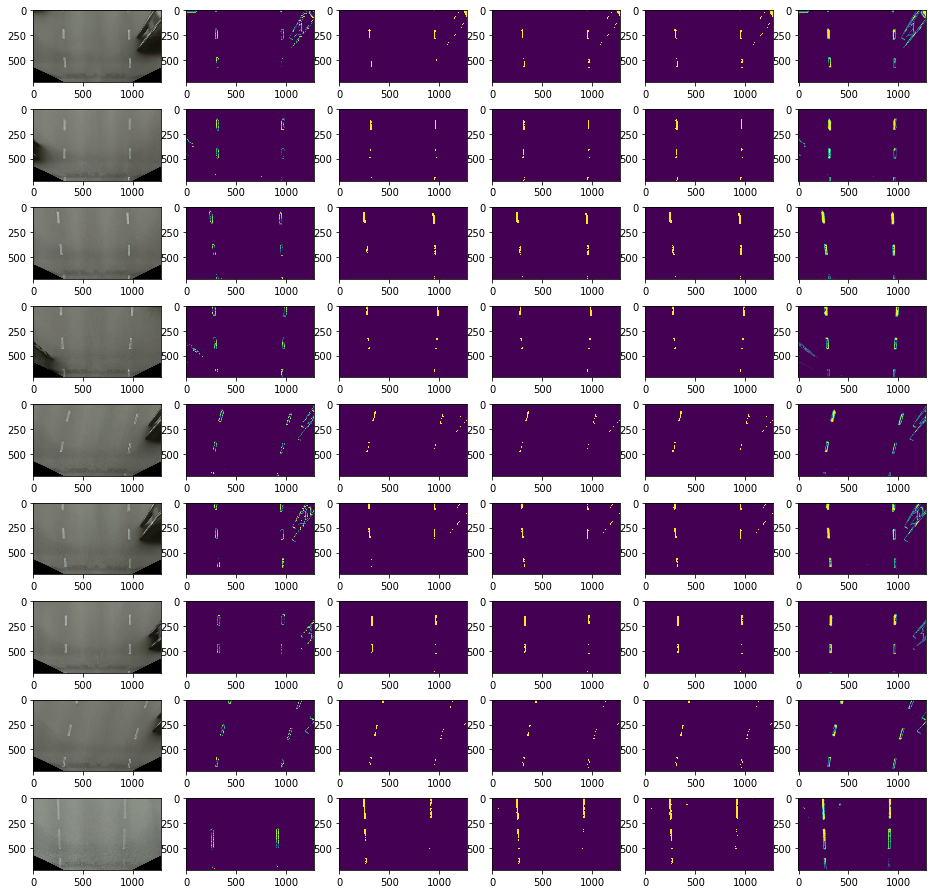

In [19]:

undistImages = glob.glob("./samples/road_samples_1/undistorted/*.png")

fig = plt.figure(figsize=(16, 16))
columns = 6
rows = 9
i = 1

for image in undistImages:
    img = cv2.imread(image)
    combinedBinary, edges, imgRGB_r, imgHLS_l, imgLAB_l = laneBinaryImage(img)
    combinedBinary.dtype='uint8'
    cv2.imwrite("./samples/road_samples_1/binary/"+os.path.basename(image).replace("_undist.png", "_bin.png"), combinedBinary)
    if i <= columns * rows:
        fig.add_subplot(rows, columns, i)
        plt.imshow(warpView(img))
        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(edges)
        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgRGB_r)
        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgHLS_l)
        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgLAB_l)
        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(combinedBinary)
        i += 1

In [ ]:
# imgBin = cv2.imread("./samples/road_samples_1/binary/sample_road_img_8_bin.png")
# histogram = np.sum(imgBin[np.int(imgBin.shape[0]/2):,:], axis=0)
# plt.plot(histogram)
import sys
np.set_printoptions(threshold=sys.maxsize)

def findLanesRect(imgBin):
    histogram = np.sum(imgBin[np.int(imgSize[1] / 2):, :], axis=0)
    outImg = np.dstack((imgBin, imgBin, imgBin)) * 255
    # outImg = imgBin.copy()
    #plt.imshow(outImg)
    midX = np.int(imgSize[0] / 2)
    
    #average starting base for left and right line
    leftX_base = np.int(np.argmax(histogram[:midX]))
    rightX_base = np.int(np.argmax(histogram[midX:]) + midX)
    
    margin = 80
    windowsNum = 8
    
    windowHeight = np.int(imgSize[1] / windowsNum)
    
    nonzero = imgBin.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])
    
    
    leftX_current, rightX_current = leftX_base, rightX_base
    pixelsThresh = 10
    
    leftLanePix = []
    rightLanePix = []
    
    for window in range(windowsNum):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = imgBin.shape[0] - (window+1)*windowHeight
        win_y_high = imgBin.shape[0] - window*windowHeight
        win_xleft_low = leftX_current - margin
        win_xleft_high = leftX_current + margin
        win_xright_low = rightX_current - margin
        win_xright_high = rightX_current + margin
        # print(win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high)
        # Draw the windows on the visualization image
        cv2.rectangle(outImg,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(outImg,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroY >= win_y_low) & (nonzeroY < win_y_high) & (nonzeroX >= win_xleft_low) & (nonzeroX < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroY >= win_y_low) & (nonzeroY < win_y_high) & (nonzeroX >= win_xright_low) & (nonzeroX < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        leftLanePix.append(good_left_inds)
        rightLanePix.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > pixelsThresh:
            leftX_current = np.int(np.mean(nonzeroX[good_left_inds]))
        if len(good_right_inds) > pixelsThresh:        
            rightX_current = np.int(np.mean(nonzeroX[good_right_inds]))
        
    leftLanePix = np.concatenate(leftLanePix)
    rightLanePix = np.concatenate(rightLanePix)
    
    # Extract left and right line pixel positions
    leftX = nonzeroX[leftLanePix]
    leftY = nonzeroY[leftLanePix]
    rightX = nonzeroX[rightLanePix]
    rightY = nonzeroY[rightLanePix]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(leftY, leftX, 2)
    right_fit = np.polyfit(rightY, rightX, 2)
    return left_fit, right_fit, leftLanePix, rightLanePix, nonzeroX, nonzeroY, outImg
    

In [ ]:
binImages = glob.glob("./samples/road_samples_1/binary/*.png")

columns = 2
rows = 9
i = 1
fig = plt.figure(figsize = [15, 45])

for binImg in binImages:
    imgBin = cv2.imread(binImg)
    #convert to binary because saved files are not really binary
    imgBin = imgBin[:, :, 0]
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = findLanesRect(imgBin)
    
    ploty = np.linspace(0, imgBin.shape[0]-1, imgBin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # out_img = np.zeros_like(np.dstack((warped, warped, warped)))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    cv2.imwrite("./samples/road_samples_1/found_lanes_rect/"+os.path.basename(binImg).replace("_bin.png", "_found_rect.png"), out_img)
    
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.imshow(imgBin)
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [ ]:
def findLanesMargins(imgBin, leftFit, rightFit):
    nonzero = imgBin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
    right_lane_inds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, imgBin.shape[0]-1, imgBin.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty


In [ ]:
#vizualize

binImages = glob.glob("./samples/road_samples_1/binary/*.png")

columns = 2
rows = 9
i = 1
fig = plt.figure(figsize = [15, 45])

for binImg in binImages:
    imgBin = cv2.imread(binImg)
    #convert to binary because saved files are not really binary
    imgBin = imgBin[:, :, 0]
    
    margin = 50
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, _ = findLanesRect(imgBin)
    left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty = findLanesMargins(imgBin, left_fit, right_fit)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((imgBin, imgBin, imgBin))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    cv2.imwrite("./samples/road_samples_1/found_lanes_margin/"+os.path.basename(binImg).replace("_bin.png", "_found_margin.png"), result)

    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.imshow(imgBin)
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)